<a href="https://colab.research.google.com/github/itzem-vg/Practicos-SIS420-COM200/blob/main/LAB6/1Presentado_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LABORATORIO 6


Este es un entrenamiento y prueba de aprendizaje por refuerzo del juego de carta Black Jack
donde elaboramos un modelo que logra jugar el juego de una manera efectiva

Grupo 4

Integrantes:

1. Aly Delgado Danner Abel
2. Lujan Renteria
3. Itzel Emily Velasquez Guerra
4. Julio Cesar Ortega Albarado
5. Rojas Vasquez Sheila

#  Blackjack
El [blackjack](https://https://gymnasium.farama.org/environments/toy_text/blackjack/) es un juego de cartas en el que el objetivo es vencer al crupier obteniendo cartas cuya suma se acerque más a 21 (sin pasarse de 21) que las cartas del crupier.

El juego comienza con el crupier en posesión de una carta boca arriba y otra boca abajo, mientras que el jugador tiene dos cartas boca arriba. Todas las cartas se extraen de un mazo infinito (es decir, con reposición).

Los valores de las cartas son:

* Las cartas con figuras (Jota, Reina, Rey) tienen un valor en puntos de 10.

* Los ases pueden contar como 11 (llamado "as utilizable") o como 1.

* Las cartas numéricas (2-9) tienen un valor igual a su número.

##Espacio de Acción

`Discrete(2)`

Este espacio significa que hay dos acciones posibles que el agente puede realizar en cada turno:


*    [0] "Palo" o "Stand"— El jugador decide no tomar más cartas.
*  [1] "Golpear - Pedir carta" o "Hit" — El jugador toma una carta adicional.

--------------------------------------------------------------------------
##Espacio de Observación
El espacio de observación describe la información que el agente (el jugador)
`Tuple(Discrete(32), Discrete(11), Discrete(2))`

Este espacio de observación está estructurado como una tupla de tres valores discretos, que describe el estado actual del juego desde la perspectiva del agente (el jugador):

- `Discrete(32)`:suma total de puntos del jugador, desde un mínimo hasta un máximo de 32 puntos. Aunque el valor máximo en Blackjack es 21, este rango cubre valores superiores para representar situaciones en las que el jugador puede “pasarse” de 21.

- `Discrete(11)`: Representa el valor de la carta expuesta del crupier, de 1 a 10. Aquí, el valor 1 se refiere a un As, que puede contar como 1 o 11 según la situación.

- `Discrete(2)`: Indica si el jugador tiene un As utilizable en su mano:

*[0] : No tiene un As utilizable (un As que cuente como 11).*

*[1]: Tiene un As utilizable.*

# Ecuación de Q-learning
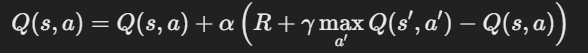

In [1]:
%matplotlib inline

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 24.5 MB/s eta 0:00:00


## Entrenamiento del modelo

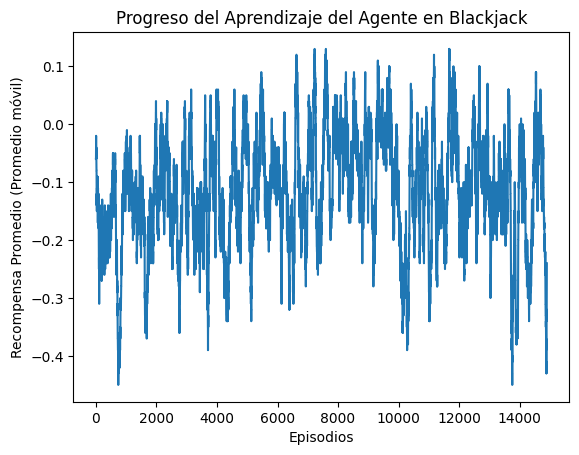

In [5]:
import gymnasium as gym
import numpy as np
import pickle # Guardar una tabla que el agente usa para recordar sus decisiones
import matplotlib.pyplot as plt

# Inicializar el entorno
env = gym.make("Blackjack-v1", natural=False)
"""
render_mode="human" -> permite visualizar el entorno.
natural=False  -> desactiva la regla de “blackjack natural” (21 con un As y una carta de valor 10) es el mejor inicio posible y usualmente resulta en una victoria automática.
-------------------------------------------------------------------------------------------
"""

# Parámetros de Q-learning
alpha = 0.1     # Tasa de aprendizaje -> cuánto se actualizan los valores en la Q-table después de cada paso.
gamma = 0.99    # Factor de descuento -> determina cuánto se valoran las recompensas futuras
epsilon = 0.1   # Tasa de exploración ->  tasa de exploración, probabilidad de que el agente elija una acción aleatoria en lugar de la mejor acción conocida (estrategia ε-greedy).


"""
GAMA:
0 Recompensas inmediatas
1 recompensas futuras

EPSILON
Hay un 10% de probabilidad de que el agente elija una acción aleatoria (por ejemplo, “hit” o “stand”).
Hay un 90% de probabilidad de que el agente elija la mejor acción según su Q-table (la acción con el valor Q más alto en el estado actual).

épsilon (ε) es cercano a 0 , el agente tiende a explotar mucho más y explorar mucho menos.
-------------------------------------------------------------------------------------------
"""

# Inicializar Q-table con ceros para cada combinación posible de estado y acción
q_table = {}
for player_sum in range(4, 22):               # Suma actual del jugador (4 a 21)
    for dealer_card in range(1, 11):           # Carta visible del crupier (1 a 10)
        for usable_ace in [0, 1]:              # As utilizable (0 o 1)
            q_table[(player_sum, dealer_card, usable_ace)] = [0, 0]  # Inicializar valores de acción (stand, hit)
                                                                     # agente no tiene información sobre qué acciones son buenas o malas


"""
Los estados están definidos por tres valores:
player_sum: -> La suma de cartas del jugador (de 4 a 21).
dealer_card: -> La carta visible del crupier (de 1 a 10).
usable_ace: -> Indica si el jugador tiene un As utilizable (0 o 1).

-------------------------------------------------------------------------------------------
"""

# Definir la política de acción (ε-greedy)
#Función decide qué acción tomar en un estado dado
def choose_action(state, training=True):
    if training and np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

"""
training: Controla si el agente está en modo de entrenamiento ( True) o en modo de evaluación ( False).
          En modo de evaluación, el agente solo explotará la mejor acción en cada estado (ignorará el valor de epsilon).

-------------------------------------------------------------------------------------------
"""

# Lista para registrar las recompensas por episodio
rewards_per_episode = []


# ENTRENA el agente con Q-learning
for episode in range(15000):
    state, info = env.reset() # Quitar la semilla para obtener variabilidad en cada episodio
                               #cada episodio, se reinicia el entorno
    done = False
    total_reward = 0



    while not done: # Mientras el episodio no haya terminado ( done es False)
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)#"hit" (pedir carta) o "stand" (plantarse)
                                                                            #reward 1(gano), 0(empate), -1(perdio)
        done = terminated or truncated #para saber si el juego ha terminado.
                                       #done = true (si toma una de las condiciones

        # Actualizar Q-table usando la ecuación de Q-learning
        if not done:
            next_action = np.argmax(q_table[next_state]) #Aquí se determina la mejor acción a tomar en el siguiente estado
            #Ecuaciónde Q-learning que actualiza el valor Q para la acción actual (action) en el estado actual
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        # Acumular la recompensa
        total_reward += reward
        state = next_state

    # Guardar la recompensa total del episodio
    rewards_per_episode.append(total_reward)


"""
Si el episodio no ha terminado, el agente:
Calcula la mejor acción futura ( next_action = np.argmax(q_table[next_state])).
          Q ( s ,a )=Q ( s ,a )+alfa×( R+gamma×Q ( s)  ",a " )−Q ( s ,a ))

Si el episodio ha terminado, la actualización solo incluye la recompensa obtenida, ya que no hay un siguiente estado.
-------------------------------------------------------------------------------------------
"""


# Guardar la Q-table en un archivo
with open("q_table_blackjack.pkl", "wb") as file:
    pickle.dump(q_table, file)

"""
"w": (escribir). archivo abrirá en modo de escritura. Si el archivo especificado no existe, se creará uno nuevo. Si ya existe, su contenido se sobrescribirá.
"b": (binario). archivo  abrirá en modo binario, necesario para manejar correctamente los datos cuando se trabaja con el módulo pickle, que guarda los datos en formato binario.
-------------------------------------------------------------------------------------------
"""
# Suavizar la recompensa usando un promedio móvil para mejorar la visualización
window_size = 100
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')

# Graficar las recompensas suavizadas por episodio
plt.plot(smoothed_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (Promedio móvil)')
plt.title('Progreso del Aprendizaje del Agente en Blackjack')
plt.show()


## Q-table
Valores de acciones para cada estado

In [6]:
# Imprimir la Q-table
for state, actions in q_table.items():
    print(f"Estado {state}: Quedarse con las cartas={actions[0]:.2f}, Tomar una carta={actions[1]:.2f}")

Estado (4, 1, 0): Quedarse con las cartas=-0.18, Tomar una carta=-0.13
Estado (4, 1, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 2, 0): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 2, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 3, 0): Quedarse con las cartas=-0.11, Tomar una carta=-0.06
Estado (4, 3, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 4, 0): Quedarse con las cartas=0.10, Tomar una carta=-0.02
Estado (4, 4, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 5, 0): Quedarse con las cartas=-0.10, Tomar una carta=0.07
Estado (4, 5, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 6, 0): Quedarse con las cartas=-0.10, Tomar una carta=0.04
Estado (4, 6, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 7, 0): Quedarse con las cartas=-0.19, Tomar una carta=-0.10
Estado (4, 7, 1): Quedarse con las cartas=0.00, Tomar una carta=0.00
Estado (4, 8, 0): Quedars

## Prueba del modelo con EXPLOTACION

In [7]:
# Prueba del agente después de entrenar usando la Q-table guardada
def test_agent(num_episodes=50):  # Reducimos el número de episodios para hacer el resultado más legible
    wins, losses, draws = 0, 0, 0 #(victorias, derrotas, empates)

    # Cargar la Q-table guardada
    with open("q_table_blackjack.pkl", "rb") as file:
        q_table = pickle.load(file)

    # Jugar con el agente entrenado
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_steps = []  # Lista para almacenar el historial de jugadas del episodio
        final_player_sum = None

        print(f"\n--- Episodio {episode + 1} ---")

        while not done:
            # Obtener la acción de la Q-table
            action = np.argmax(q_table[state])  # Seleccionar la mejor acción según la Q-table

            # Registrar el estado actual y la acción
            player_sum, dealer_card, usable_ace = state
            action_name = "Golpear" if action == 1 else "Palo"
            episode_steps.append({
                "Jugador": player_sum,
                "Carta Crupier": dealer_card,
                "As Utilizable": usable_ace,
                "Acción": action_name
            })

            # Si el jugador elige "palo", guardamos la suma final del jugador
            if action == 0:  # Si elige "Palo"
                final_player_sum = player_sum

            # Realizar la acción
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        # Resultado final del episodio
        if reward == 1:
            wins += 1
            outcome = "Ganó"
        elif reward == -1:
            losses += 1
            outcome = "Perdió"
        else:
            draws += 1
            outcome = "Empató"

        # Mostrar el historial del episodio
        print(f"Resultado: {outcome}")
        for step, details in enumerate(episode_steps):
            print(f"Jugada {step + 1}: Jugador={details['Jugador']}, "
                  f"Carta Crupier={details['Carta Crupier']}, "
                  f"As Utilizable={details['As Utilizable']}, "
                  f"Acción={details['Acción']}")

        # Mostrar el puntaje final del jugador
        print(f"Jugador terminó con: {final_player_sum}")

    print(f"\nResultados tras {num_episodes} episodios:")
    print(f"Victorias: {wins}")
    print(f"Derrotas: {losses}")
    print(f"Empates: {draws}")
    print(f"Total ganadas: {wins}")
    print(f"Total perdidas: {losses}")

# Ejecutar el test del agente
test_agent()



--- Episodio 1 ---
Resultado: Perdió
Jugada 1: Jugador=11, Carta Crupier=1, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=14, Carta Crupier=1, As Utilizable=0, Acción=Golpear
Jugador terminó con: None

--- Episodio 2 ---
Resultado: Perdió
Jugada 1: Jugador=6, Carta Crupier=8, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=13, Carta Crupier=8, As Utilizable=0, Acción=Golpear
Jugador terminó con: None

--- Episodio 3 ---
Resultado: Perdió
Jugada 1: Jugador=13, Carta Crupier=8, As Utilizable=0, Acción=Golpear
Jugador terminó con: None

--- Episodio 4 ---
Resultado: Ganó
Jugada 1: Jugador=15, Carta Crupier=2, As Utilizable=1, Acción=Golpear
Jugada 2: Jugador=15, Carta Crupier=2, As Utilizable=0, Acción=Palo
Jugador terminó con: 15

--- Episodio 5 ---
Resultado: Perdió
Jugada 1: Jugador=13, Carta Crupier=8, As Utilizable=0, Acción=Golpear
Jugador terminó con: None

--- Episodio 6 ---
Resultado: Ganó
Jugada 1: Jugador=20, Carta Crupier=10, As Utilizable=0, Acción=Palo
Jugador terminó